In [153]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from math import e
from marchMadnessBracket.torch_bracket import *

In [154]:
xpower = torch.arange(1, 65,dtype=float)
xp = torch.full((1, 64), 1.)

In [155]:
xpower,xp

(tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
         15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
         29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42.,
         43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55., 56.,
         57., 58., 59., 60., 61., 62., 63., 64.], dtype=torch.float64),
 tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]))

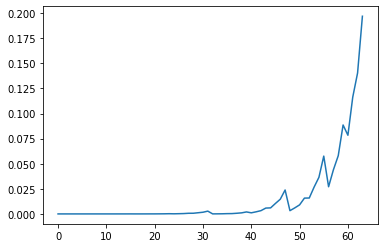

In [156]:
prob = do_full_bracket(xpower,xp)
plt.plot(prob)

In [157]:
from marchMadnessBracket.utils import *
from marchMadnessBracket.Team import Team
from marchMadnessBracket.Bracket import Bracket
teams = [['Gonzaga', 25.9],
 ['NORF/APPST', 4.2],
 ['Oklahoma', 14.1],
 ['Missouri', 11.4],
 ['Creighton', 16.9],
 ['UCSB', 6.4],
 ['Virginia', 16.2],
 ['Ohio', 5.2],
 ['USC', 15.9],
 ['WICH/DRKE', 8.4],
 ['Kansas', 17.1],
 ['Eastern Wash.', 4.6],
 ['Oregon', 13.9],
 ['VCU', 10.7],
 ['Iowa', 20.9],
 ['Grand Canyon', 4.5],
 ['Michigan', 20.4],
 ['MSM/TXSO', 4.0],
 ['LSU', 14.6],
 ['St. Bonaventure', 12.7],
 ['Colorado', 16.0],
 ['Georgetown', 9.7],
 ['Florida St.', 16.7],
 ['N.C. Greensboro', 5.1],
 ['BYU', 13.9],
 ['MSU/UCLA', 12.6],
 ['Texas', 16.5],
 ['Abilene Christian', 6.0],
 ['Connecticut', 15.2],
 ['Maryland', 12.6],
 ['Alabama', 18.0],
 ['Iona', 0.1],
 ['Baylor', 23.1],
 ['Hartford', 2.4],
 ['North Carolina', 14.9],
 ['Wisconsin', 15.9],
 ['Villanova', 17.9],
 ['Winthrop', 5.8],
 ['Purdue', 15.2],
 ['North Texas', 7.9],
 ['Texas Tech', 16.9],
 ['Utah St.', 12.1],
 ['Arkansas', 16.2],
 ['Colgate', 8.8],
 ['Florida', 13.2],
 ['Virginia Tech', 12.3],
 ['Ohio St.', 17.5],
 ['Oral Roberts', 0.9],
 ['Illinois', 21.7],
 ['Drexel', 0.8],
 ['Loyola (IL)', 13.9],
 ['Georgia Tech', 13.1],
 ['Tennessee', 16.5],
 ['Oregon St.', 7.8],
 ['Oklahoma St.', 14.3],
 ['Liberty', 4.6],
 ['SDSU', 14.5],
 ['Syracuse', 12.3],
 ['West Virginia', 16.2],
 ['Morehead St.', 0.1],
 ['Clemson', 12.5],
 ['Rutgers', 13.0],
 ['Houston', 19.9],
 ['Cleveland St.', 2.0]]

teams = list(map(lambda x: Team(*x), teams))

In [158]:
ratings = []
names = []
for team in teams:
    ratings.append(team.rating)
    names.append(team.name)

In [159]:
ratings_tensor = torch.Tensor(ratings)

tensor(1.0000)

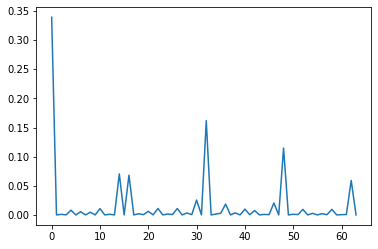

In [160]:
prob = do_full_bracket(ratings_tensor,xp)
plt.plot(prob)
prob.sum()

In [161]:
names_prob = list(zip(names,prob))
sorted(names_prob,key=lambda x: -x[1])

[('Gonzaga', tensor(0.3393)),
 ('Baylor', tensor(0.1617)),
 ('Illinois', tensor(0.1147)),
 ('Iowa', tensor(0.0704)),
 ('Michigan', tensor(0.0682)),
 ('Houston', tensor(0.0592)),
 ('Alabama', tensor(0.0255)),
 ('Ohio St.', tensor(0.0204)),
 ('Villanova', tensor(0.0186)),
 ('Florida St.', tensor(0.0111)),
 ('Texas', tensor(0.0109)),
 ('Kansas', tensor(0.0108)),
 ('Texas Tech', tensor(0.0099)),
 ('West Virginia', tensor(0.0096)),
 ('Tennessee', tensor(0.0095)),
 ('Creighton', tensor(0.0081)),
 ('Arkansas', tensor(0.0076)),
 ('Colorado', tensor(0.0061)),
 ('Virginia', tensor(0.0055)),
 ('USC', tensor(0.0046)),
 ('Purdue', tensor(0.0034)),
 ('Connecticut', tensor(0.0033)),
 ('Wisconsin', tensor(0.0030)),
 ('Oklahoma St.', tensor(0.0027)),
 ('SDSU', tensor(0.0021)),
 ('LSU', tensor(0.0019)),
 ('BYU', tensor(0.0015)),
 ('North Carolina', tensor(0.0014)),
 ('Loyola (IL)', tensor(0.0011)),
 ('Oregon', tensor(0.0011)),
 ('Oklahoma', tensor(0.0009)),
 ('Florida', tensor(0.0009)),
 ('Rutgers', ten

In [162]:
human_picks = {'Gonzaga': [97.7184, 93.121, 85.7853, 72.3422, 59.9904, 43.5631],
 'Baylor': [96.1392, 82.5877, 70.2927, 50.7066, 29.6117, 8.6977],
 'Iowa': [95.9706, 77.2913, 48.3535, 10.8907, 5.5001, 2.4422],
 'Michigan': [95.6712, 84.333, 66.9569, 46.4992, 14.843, 9.0988],
 'Illinois': [95.5053, 87.9137, 72.8701, 57.482, 33.7767, 15.6837],
 'Ohio St.': [95.2931, 80.7313, 59.1219, 24.7422, 10.2383, 3.0282],
 'Kansas': [93.9874, 70.0629, 33.5628, 7.9222, 3.9552, 2.0714],
 'Houston': [93.5286, 76.5244, 43.6078, 14.1668, 5.8786, 1.6965],
 'Texas': [92.6278, 69.8685, 36.6484, 14.919, 2.9774, 1.1377],
 'Alabama': [92.4722, 73.4387, 42.4985, 19.3409, 4.5083, 1.8481],
 'West Virginia': [90.7206, 62.7244, 34.7381, 9.3002, 3.4422, 0.9458],
 'Florida St.': [90.2665, 59.6703, 18.6316, 7.7381, 1.4897, 0.5972],
 'Purdue': [88.6197, 43.8941, 7.8438, 2.8696, 1.0671, 0.3829],
 'Arkansas': [85.1917, 51.1321, 17.9848, 5.3602, 1.8732, 0.5729],
 'Virginia': [84.5838, 53.8875, 6.9071, 3.2329, 1.3913, 0.6729],
 'Oklahoma St.': [84.2984, 55.0067, 13.0297, 7.7763, 3.3117, 0.9377],
 'USC': [79.3014, 23.2515, 8.0756, 0.857, 0.3313, 0.1768],
 'Tennessee': [75.7456, 33.7112, 6.6588, 2.5973, 0.8784, 0.288],
 'Creighton': [74.9402, 33.7112, 2.271, 0.7962, 0.3353, 0.1445],
 'Villanova': [73.7188, 44.7711, 11.067, 5.7852, 3.0688, 0.9144],
 'Texas Tech': [72.9478, 36.7414, 12.5516, 2.4436, 0.773, 0.2647],
 'LSU': [66.9249, 9.3682, 4.1221, 1.3564, 0.3503, 0.1576],
 'Oregon': [66.9175, 16.454, 5.9151, 0.9804, 0.4307, 0.2193],
 'BYU': [66.6404, 18.4329, 7.198, 1.2066, 0.249, 0.1122],
 'Oklahoma': [60.8307, 2.9651, 1.6843, 0.4838, 0.1707, 0.0738],
 'Clemson': [58.0413, 13.1452, 3.9398, 1.1518, 0.3965, 0.1273],
 'SDSU': [55.768, 22.1122, 9.4254, 1.6738, 0.6234, 0.2577],
 'North Carolina': [52.9535, 9.0819, 5.2043, 2.7912, 1.3622, 0.6709],
 'Florida': [51.2196, 9.891, 3.6586, 0.9226, 0.4367, 0.1748],
 'Loyola (IL)': [50.4532, 4.9852, 2.1333, 0.8942, 0.3754, 0.1586],
 'Connecticut': [49.8638, 13.0389, 4.8329, 1.6689, 0.525, 0.3223],
 'Colorado': [48.52, 19.7513, 3.2814, 1.1841, 0.2961, 0.1344],
 'Georgetown': [47.6266, 16.0586, 2.9614, 1.2771, 0.4859, 0.3193],
 'Maryland': [46.0391, 8.7784, 2.6007, 0.4975, 0.1526, 0.0717],
 'Georgia Tech': [45.0438, 3.7157, 1.5379, 0.6454, 0.254, 0.1213],
 'Virginia Tech': [44.4785, 5.9503, 2.3641, 0.4094, 0.1576, 0.0717],
 'Wisconsin': [43.1931, 5.282, 2.3845, 1.044, 0.3724, 0.19],
 'Syracuse': [39.6604, 10.5793, 3.7624, 1.3271, 0.7298, 0.5244],
 'Rutgers': [37.2537, 6.2193, 1.344, 0.2938, 0.1154, 0.0606],
 'Missouri': [36.4669, 1.7444, 0.7021, 0.2938, 0.1265, 0.0738],
 'VCU': [30.3153, 3.4553, 0.8562, 0.1606, 0.0663, 0.0293],
 'St. Bonaventure': [29.003, 2.5955, 0.799, 0.3056, 0.0914, 0.0404],
 'MSU/UCLA': [27.409, 6.4797, 1.9685, 0.6679, 0.2439, 0.1768],
 'Utah St.': [22.9237, 5.3634, 0.864, 0.2047, 0.0803, 0.0374],
 'UCSB': [22.5789, 5.4811, 0.4073, 0.1704, 0.0853, 0.0404],
 'Winthrop': [22.5307, 6.8292, 0.5498, 0.237, 0.0964, 0.0333],
 'Oregon St.': [19.7746, 3.9847, 0.6768, 0.2674, 0.1446, 0.0647],
 'WICH/DRKE': [16.1177, 2.6884, 0.5227, 0.1401, 0.0632, 0.0323],
 'Ohio': [13.1846, 4.8292, 0.6594, 0.191, 0.0823, 0.0354],
 'Liberty': [11.4868, 4.1752, 0.5789, 0.1988, 0.0783, 0.0313],
 'Colgate': [11.0921, 3.843, 0.9551, 0.3379, 0.1968, 0.0354],
 'North Texas': [7.7086, 1.6659, 0.3268, 0.1332, 0.0572, 0.0364],
 'N.C. Greensboro': [6.0627, 1.5481, 0.3093, 0.1234, 0.0542, 0.0202],
 'Morehead St.': [5.1619, 1.4074, 0.3956, 0.141, 0.0723, 0.0263],
 'Iona': [4.667, 1.9474, 0.9125, 0.5543, 0.4136, 0.0404],
 'Eastern Wash.': [4.0507, 1.259, 0.3442, 0.1156, 0.0522, 0.0212],
 'Abilene Christian': [4.0443, 1.4897, 0.4897, 0.2272, 0.0763, 0.0404],
 'Cleveland St.': [2.9961, 1.0646, 0.3888, 0.143, 0.0632, 0.0303],
 'Grand Canyon': [2.6959, 1.0321, 0.4596, 0.1704, 0.0863, 0.0495],
 'Oral Roberts': [1.9211, 0.7573, 0.3384, 0.1303, 0.0532, 0.0253],
 'Drexel': [1.6134, 0.6788, 0.3801, 0.2125, 0.0984, 0.0546],
 'Hartford': [1.5476, 0.539, 0.289, 0.1694, 0.0803, 0.0424],
 'MSM/TXSO': [0.9814, 0.4222, 0.2405, 0.141, 0.0552, 0.0202],
 'NORF/APPST': [0.8711, 0.3877, 0.2075, 0.1156, 0.0602, 0.0293]}

In [272]:
loss_func = nn.BCELoss()
loss_func = nn.KLDivLoss()
loss_func = nn.MSELoss()

In [273]:
target = torch.tensor([human_picks[name][-1] for name in names])
target = target/target.sum()
target

tensor([4.3563e-01, 2.9300e-04, 7.3800e-04, 7.3800e-04, 1.4450e-03, 4.0400e-04,
        6.7290e-03, 3.5400e-04, 1.7680e-03, 3.2300e-04, 2.0714e-02, 2.1200e-04,
        2.1930e-03, 2.9300e-04, 2.4422e-02, 4.9500e-04, 9.0988e-02, 2.0200e-04,
        1.5760e-03, 4.0400e-04, 1.3440e-03, 3.1930e-03, 5.9720e-03, 2.0200e-04,
        1.1220e-03, 1.7680e-03, 1.1377e-02, 4.0400e-04, 3.2230e-03, 7.1700e-04,
        1.8481e-02, 4.0400e-04, 8.6977e-02, 4.2400e-04, 6.7090e-03, 1.9000e-03,
        9.1440e-03, 3.3300e-04, 3.8290e-03, 3.6400e-04, 2.6470e-03, 3.7400e-04,
        5.7290e-03, 3.5400e-04, 1.7480e-03, 7.1700e-04, 3.0282e-02, 2.5300e-04,
        1.5684e-01, 5.4600e-04, 1.5860e-03, 1.2130e-03, 2.8800e-03, 6.4700e-04,
        9.3770e-03, 3.1300e-04, 2.5770e-03, 5.2440e-03, 9.4580e-03, 2.6300e-04,
        1.2730e-03, 6.0600e-04, 1.6965e-02, 3.0300e-04])

In [274]:
human_ratings_tensor = torch.tensor(ratings, requires_grad=True)
ratings_tensor

tensor([25.9000,  4.2000, 14.1000, 11.4000, 16.9000,  6.4000, 16.2000,  5.2000,
        15.9000,  8.4000, 17.1000,  4.6000, 13.9000, 10.7000, 20.9000,  4.5000,
        20.4000,  4.0000, 14.6000, 12.7000, 16.0000,  9.7000, 16.7000,  5.1000,
        13.9000, 12.6000, 16.5000,  6.0000, 15.2000, 12.6000, 18.0000,  0.1000,
        23.1000,  2.4000, 14.9000, 15.9000, 17.9000,  5.8000, 15.2000,  7.9000,
        16.9000, 12.1000, 16.2000,  8.8000, 13.2000, 12.3000, 17.5000,  0.9000,
        21.7000,  0.8000, 13.9000, 13.1000, 16.5000,  7.8000, 14.3000,  4.6000,
        14.5000, 12.3000, 16.2000,  0.1000, 12.5000, 13.0000, 19.9000,  2.0000])

In [275]:
optimizer = torch.optim.Adam([human_ratings_tensor], lr=1e-3)
losses =[]

0 0.00033932508
100 7.248414e-07
200 2.5214146e-07
300 1.5776068e-07
400 1.214597e-07
500 1.0779548e-07
600 9.883905e-08
700 9.277217e-08
800 8.582058e-08
900 7.836809e-08


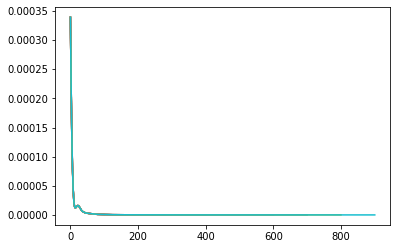

In [276]:
for i in range(1000):
    optimizer.zero_grad()
    prob = do_full_bracket(human_ratings_tensor,xp)
    loss = loss_func(prob,target)
    loss.backward()
    losses.append(loss.detach().numpy())
    optimizer.step()
    if i%100==0:
        print(i,loss.detach().numpy())
        plt.plot(losses)
        #print(ratings_tensor)


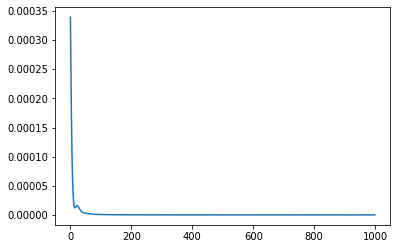

In [277]:
ratings_tensor
plt.plot(losses)

In [309]:

human_ratings_np = human_ratings_tensor.detach().numpy()
prob_np = prob.detach().numpy()
target_np = target.numpy()
names_prob = list(zip(names,human_ratings_np,prob_np,target_np))
sorted(names_prob,key=lambda x: -x[2])

[('Gonzaga', 27.333015, 0.4358231, 0.43563056, 25.9),
 ('Illinois', 23.175295, 0.15702544, 0.15683684, 21.7),
 ('Michigan', 21.855366, 0.09117988, 0.090987906, 20.4),
 ('Baylor', 21.708778, 0.08717312, 0.08697691, 23.1),
 ('Ohio St.', 18.66779, 0.030475898, 0.030281968, 17.5),
 ('Iowa', 19.219692, 0.024617225, 0.024421975, 20.9),
 ('Kansas', 18.636965, 0.020906795, 0.02071398, 17.1),
 ('Alabama', 18.116446, 0.018675072, 0.01848098, 18.0),
 ('Houston', 17.722143, 0.017157003, 0.016964983, 19.9),
 ('Texas', 17.308342, 0.01157037, 0.011376988, 16.5),
 ('West Virginia', 16.689497, 0.00964631, 0.0094579905, 16.2),
 ('Oklahoma St.', 16.796816, 0.009558114, 0.009376991, 14.3),
 ('Villanova', 16.70532, 0.009343318, 0.00914399, 17.9),
 ('Virginia', 16.728817, 0.006926071, 0.0067289937, 16.2),
 ('North Carolina', 17.471064, 0.0069096885, 0.006708993, 14.9),
 ('Florida St.', 16.328344, 0.0061670137, 0.005971994, 16.7),
 ('Arkansas', 15.912425, 0.005923794, 0.0057289945, 16.2),
 ('Syracuse', 16.68

In [312]:
names_prob = list(zip(names,human_ratings_np,ratings,human_ratings_np-ratings))
sorted(names_prob,key=lambda x: -x[3])

[('Georgetown', 16.0184, 9.7, 6.318400192260743),
 ('Syracuse', 16.680525, 12.3, 4.380524826049804),
 ('VCU', 13.389773, 10.7, 2.68977336883545),
 ('Oregon St.', 10.470352, 7.8, 2.6703521728515627),
 ('North Carolina', 17.471064, 14.9, 2.571063613891601),
 ('Oklahoma St.', 16.796816, 14.3, 2.496815872192382),
 ('MSU/UCLA', 15.086713, 12.6, 2.4867128372192386),
 ('Cleveland St.', 4.1911683, 2.0, 2.1911683082580566),
 ('UCSB', 8.547953, 6.4, 2.1479526519775387),
 ('Clemson', 14.378651, 12.5, 1.8786506652832031),
 ('Oregon', 15.717472, 13.9, 1.8174720764160153),
 ('Grand Canyon', 6.2536025, 4.5, 1.7536025047302246),
 ('Georgia Tech', 14.805324, 13.1, 1.7053236007690433),
 ('Maryland', 14.213443, 12.6, 1.6134428024291996),
 ('Florida', 14.787607, 13.2, 1.5876071929931648),
 ('Kansas', 18.636965, 17.1, 1.5369647979736314),
 ('Virginia Tech', 13.778135, 12.3, 1.4781352996826165),
 ('Illinois', 23.175295, 21.7, 1.4752948760986335),
 ('Michigan', 21.855366, 20.4, 1.4553657531738295),
 ('Gonzag

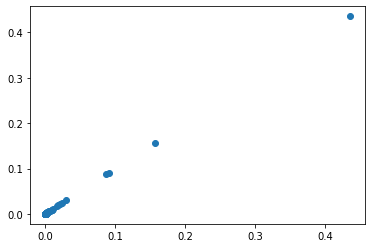

In [279]:
plt.scatter(target_np,prob_np)


In [705]:
from scipy.stats import norm

x = np.linspace(-20,20,100)
norm = norm.cdf(x, loc=0, scale=9.5)
logisitic = (1/(1+(e*2)**(-(x)/9.5) ) )

In [305]:
targets = [[human_picks[name][x]/100. for name in names] for x in range(6)]

In [306]:
def do_full_bracket_print(rankings,prob):
    probs = []
    power = math.log(rankings.shape[0])/math.log(2)
    assert power.is_integer(), "must be multiple of two"
    power = int(power)
    for x in range(power):
        l_power = 2**x
        prob,n_rounds = one_round(rankings,prob,2*l_power,l_power,logisitic)
        probs.append(prob.detach().numpy())
        #print(prob)
    return probs

In [307]:
predicted = do_full_bracket_print(human_ratings_tensor,xp)

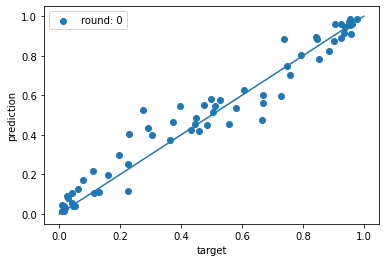

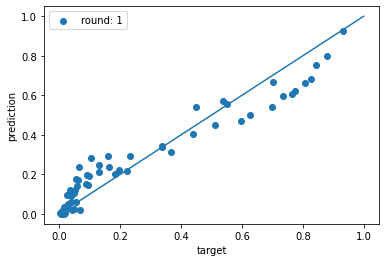

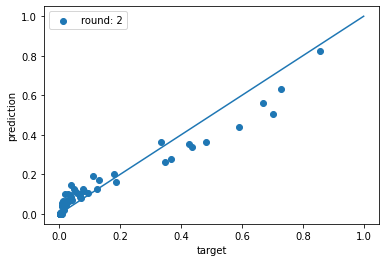

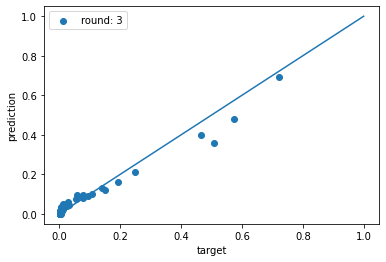

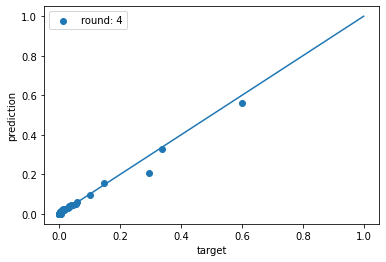

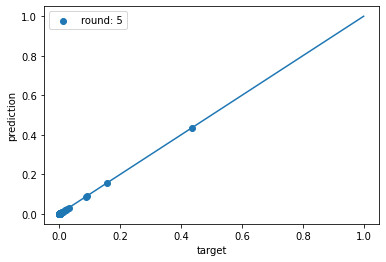

<Figure size 432x288 with 0 Axes>

In [308]:
for i,(pred, tar) in enumerate(zip(predicted,targets)):
    plt.scatter(tar,pred, label="round: {}".format(i))
    plt.ylabel("prediction")
    plt.xlabel("target")
    x = np.linspace(0,1,3)
    plt.plot(x,x)
    plt.legend()
    plt.show()
    plt.clf()

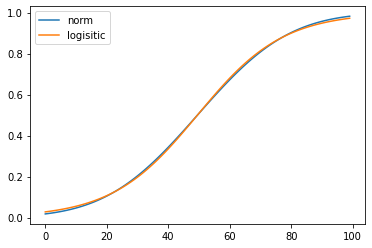

In [706]:
plt.plot(norm, label="norm")
plt.plot(logisitic, label="logisitic")
plt.legend()

In [703]:
2.7*2

5.4

In [229]:
m = nn.LogSoftmax(dim=1)
loss = nn.NLLLoss()
# input is of size N x C = 3 x 5
input = torch.randn(3, 5, requires_grad=True)
# each element in target has to have 0 <= value < C
target = torch.tensor([1, 0, 4])
output = loss(m(input), target)
output.backward()

In [230]:
input

tensor([[-0.6440, -0.6569,  0.7668, -1.3241, -0.2552],
        [ 0.5537,  1.8828, -0.3636,  0.9727,  1.1204],
        [-1.0023,  1.0026, -0.5451, -0.3423,  1.0632]], requires_grad=True)

In [231]:
target

tensor([1, 0, 4])